# Volcano plots for proteomics
This notebook generates volcano plots for each strain in DBTL1.

A volcano plot compares proteins between a control and experimental condition. On the x axis, we plot the fold change of the protein between the experimental condition and the control. On the y axis we plot the p-value of a students t test of the distributions between the experimental replicates and the control. Thus, signicantly different proteins will be in the upper right or upper left of the plot. 

## Import packages

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

## Install `adjustText` if not already in environment

In [2]:
!pip install adjustText 
from adjustText import adjust_text 


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## import data
Log2 fold changes and log10 p-values are already calculated.

In [3]:
#.csv files preprocessed here for ease of access
df_log2=pd.read_csv('Log2.csv')
df_log10=pd.read_csv('Log10.csv')

Check headers

In [4]:
df_log2.head(3)

Protein  PP_0226_PP_0437_PP_0751-R1  PP_0226_PP_0597_PP_4678-R1  \
0  sp|A9GAJ9                   -0.720943                   -0.318413   
1  sp|O77727                   -0.720943                   -0.318413   
2  sp|O82803                   -0.720943                   -0.318413   

   PP_0226_PP_0897_PP_5288-R1  PP_0226_PP_2339_PP_3365-R1  PP_0368_PP_0597-R1  \
0                    0.042976                    1.009490           -0.558883   
1                    0.042976                   -1.236808           -0.558883   
2                    0.042976                   -1.236808           -0.558883   

   PP_0368_PP_0812_PP_0944-R1  PP_0368_PP_4191_PP_4192-R1  \
0                    0.032114                   -0.152038   
1                    0.032114                   -0.152038   
2                    0.032114                   -0.152038   

   PP_0437_PP_0528_PP_3578-R1  PP_0437_PP_3365-R1  ...  \
0                    1.234153           -0.078093  ...   
1                   -0.005580            5.543997  ...   
2                   -0.005580           -0.078093  ...   

   PP_2213_PP_2471_PP_4266-R1  PP_2339_PP_4186-R1  PP_2471_PP_3754_PP_4667-R1  \
0                   -0.549206           -0.169232                   -0.262158   
1                   -0.549206           -0.169232                   -0.262158   
2                   -0.549206           -0.169232                   -0.262158   

   PP_3123_PP_3755-R1  PP_3123_PP_4667-R1  PP_3123_PP_4862_PP_5186-R1  \
0            0.417216            2.022174                   -0.726425   
1            0.417216           -0.029038                   -0.726425   
2            0.417216           -0.029038                   -0.726425   

   PP_3123_PP_5288-R1  PP_3365_PP_3754-R1  PP_4122_PP_4188-R1  \
0            1.060007           -0.159279           -0.206865   
1           -0.422838           -0.159279           -0.206865   
2           -0.422838           -0.159279           -0.206865   

   PP_4189_PP_4550_PP_4862-R1  
0                   -0.338163  
1                   -0.338163  
2                   -0.338163  

[3 rows x 61 columns]

In [5]:
df_log10.head(3)

Protein  PP_0226_PP_0437_PP_0751-R1  PP_0226_PP_0597_PP_4678-R1  \
0  sp|A9GAJ9                    1.773666                    0.637098   
1  sp|O77727                    1.773666                    0.637098   
2  sp|O82803                    1.773666                    0.637098   

   PP_0226_PP_0897_PP_5288-R1  PP_0226_PP_2339_PP_3365-R1  PP_0368_PP_0597-R1  \
0                    0.067433                    0.712044            1.604392   
1                    0.067433                    2.728048            1.604392   
2                    0.067433                    2.728048            1.604392   

   PP_0368_PP_0812_PP_0944-R1  PP_0368_PP_4191_PP_4192-R1  \
0                    0.065951                     0.33914   
1                    0.065951                     0.33914   
2                    0.065951                     0.33914   

   PP_0437_PP_0528_PP_3578-R1  PP_0437_PP_3365-R1  ...  \
0                    1.367960            0.172344  ...   
1                    0.011718            1.395833  ...   
2                    0.011718            0.172344  ...   

   PP_2213_PP_2471_PP_4266-R1  PP_2339_PP_4186-R1  PP_2471_PP_3754_PP_4667-R1  \
0                    1.615782            0.385016                    0.758611   
1                    1.615782            0.385016                    0.758611   
2                    1.615782            0.385016                    0.758611   

   PP_3123_PP_3755-R1  PP_3123_PP_4667-R1  PP_3123_PP_4862_PP_5186-R1  \
0            1.215493            1.361549                    1.992765   
1            1.215493            0.061778                    1.992765   
2            1.215493            0.061778                    1.992765   

   PP_3123_PP_5288-R1  PP_3365_PP_3754-R1  PP_4122_PP_4188-R1  \
0            0.938258            0.263324            0.489151   
1            1.214189            0.263324            0.489151   
2            1.214189            0.263324            0.489151   

   PP_4189_PP_4550_PP_4862-R1  
0                    0.944703  
1                    0.944703  
2                    0.944703  

[3 rows x 61 columns]

Import dictionary to convert between protein names and PP_XXXX numbers

The proteins labeled based on canonical names, but using their locus (PP_XXXX) name is more useful for visualization.

In [6]:
name_df = pd.read_csv('../ml/data/proteomics_id_translator.csv')
name_df.head(3)

original extracted         locus primary_name  \
0                       P0AE22    P0AE22  b4055 JW4015         aphA   
1   sp|A9GAJ9|A9GAJ9_SORC5 Mcm    A9GAJ9       sce2716          mcm   
2  sp|K4JH65|K4JH65_9ACTN Gdnd    K4JH65           NaN         gdnD   

                                            organism  is_putida  
0                      Escherichia coli (strain K12)      False  
1  Sorangium cellulosum (strain So ce56) (Polyang...      False  
2                          Streptomyces sp. K01-0509      False

In [7]:
#Get the common column names between the two DataFrames
common_columns = list(set(df_log2.columns[1:]) & set(df_log10.columns[1:]))

print(common_columns)

['PP_3123_PP_4862_PP_5186-R1', 'PP_0999_PP_3578_PP_5186-R1', 'PP_3123_PP_5288-R1', 'PP_2339_PP_4186-R1', 'PP_1506_PP_4651_PP_4862-R1', 'PP_0814_PP_4192-R4', 'PP_0226_PP_0437_PP_0751-R1', 'PP_2137_PP_4189-R4', 'PP_0814_PP_4862-R4', 'PP_0813_PP_1769_PP_4191-R1', 'PP_0597_PP_1769_PP_4862-R1', 'PP_2112_PP_4189_PP_5186-R1', 'PP_0368_PP_4191_PP_4192-R1', 'PP_0437_PP_0528_PP_3578-R1', 'PP_0813_PP_4549_PP_5288-R1', 'PP_0814_PP_4192-R1', 'PP_0814_PP_5288-R1', 'PP_1319_PP_4121_PP_4667-R1', 'PP_0528_PP_5288-R1', 'PP_0437_PP_4116-R1', 'PP_0658_PP_0815_PP_4187-R1', 'PP_0774_PP_1769-R1', 'PP_0814_PP_4862-R1', 'PP_0812_PP_2095-R1', 'PP_1319_PP_1457_PP_4192-R1', 'PP_0999_PP_4120_PP_4191-R1', 'PP_0226_PP_2339_PP_3365-R1', 'PP_0812_PP_4121-R1', 'PP_0658_PP_2136-R1', 'PP_1444_PP_4189_PP_4191-R1', 'PP_1607_PP_4550-R1', 'PP_2137_PP_4011_PP_4120-R1', 'PP_2137_PP_4116_PP_4187-R1', 'PP_4189_PP_4550_PP_4862-R1', 'PP_2112_PP_4188_PP_4862-R1', 'PP_4122_PP_4188-R1', 'PP_0368_PP_0597-R1', 'PP_2471_PP_3754_PP_4667-

## Create protein name translation dataframe

Iterate through original protein names and determine if they have exactly one matching name in the translator dataframe.

If they have exactly one match, fill in the dictionary with the locus name of that protein.

If they have 0 or >1 match, use the original label.

In [8]:
translator_dict = {}
nontranslated = 0
for idx, orig_label in enumerate(df_log2['Protein']):
# for idx, orig_label in enumerate(['sp|Q88EW6']):
    matching_idx = name_df['original'].str.contains(orig_label, regex = False)
    if sum(matching_idx) == 1:
        translator_dict[orig_label] = name_df.loc[matching_idx, 'locus'].values[0]
        # print(name_df.loc[idx, 'locus'])
        # print(name_df.loc[matching_idx, 'locus'])
    else:
        translator_dict[orig_label] = orig_label
        print(f"nontranslated: {orig_label}")
        nontranslated += 1
print(f"In total, N = {nontranslated}/{len(df_log2['Protein'])} proteins were not tranlated to locus names")                                                  

nontranslated: sp|P0AE22
nontranslated: sp|Q835L3
nontranslated: sp|Q88CB2
nontranslated: sp|Q88CC3
nontranslated: sp|Q88EH0
nontranslated: sp|Q88GJ9
nontranslated: sp|Q88GX7
nontranslated: sp|Q88IU1
nontranslated: sp|Q88KG8
nontranslated: sp|Q88KI7
nontranslated: sp|Q88LF1
nontranslated: sp|Q88PL6
nontranslated: sp|Q88QV2
nontranslated: sp|Q8PW39
In total, N = 14/2187 proteins were not tranlated to locus names


## Spot check label dictionary:
Print a few protein names and their translations to check my work

In [9]:
to_print = 10
counter = 0
print('Values should match:')
for key, value in translator_dict.items():
    print(f'key: {key}\t value: {value}')
    counter+=1
    if counter > to_print: 
        break

Values should match:
key: sp|A9GAJ9	 value: sce2716
key: sp|O77727	 value: nan
key: sp|O82803	 value: nan
key: sp|O85207	 value: PP_1408
key: sp|P00552	 value: nan
key: sp|P00761	 value: nan
key: sp|P04264	 value: nan
key: sp|P0A0Z9	 value: PP_5185
key: sp|P0A101	 value: PP_3952
key: sp|P0A116	 value: PP_0010
key: sp|P0A118	 value: PP_0388


1


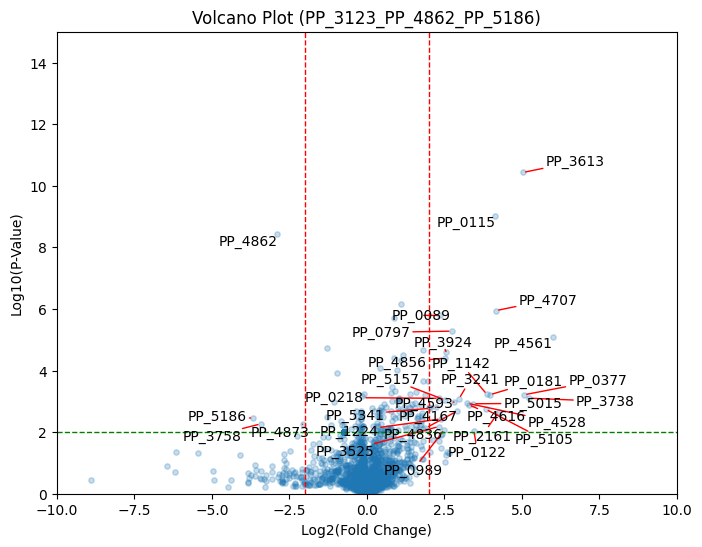

2


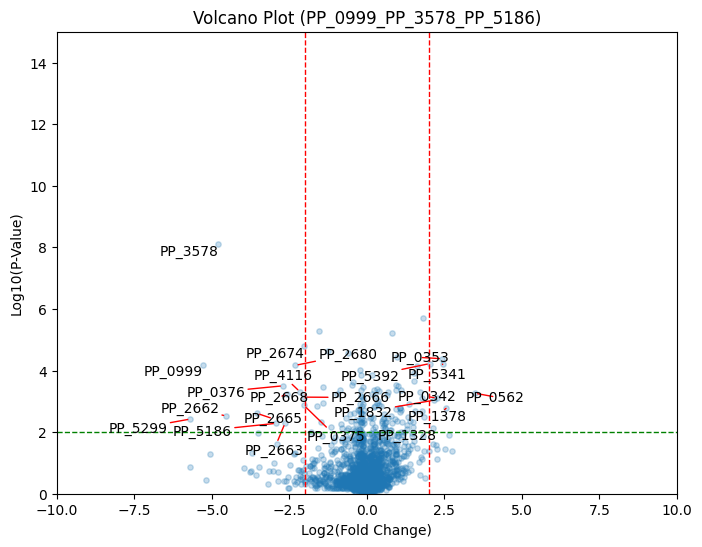

3


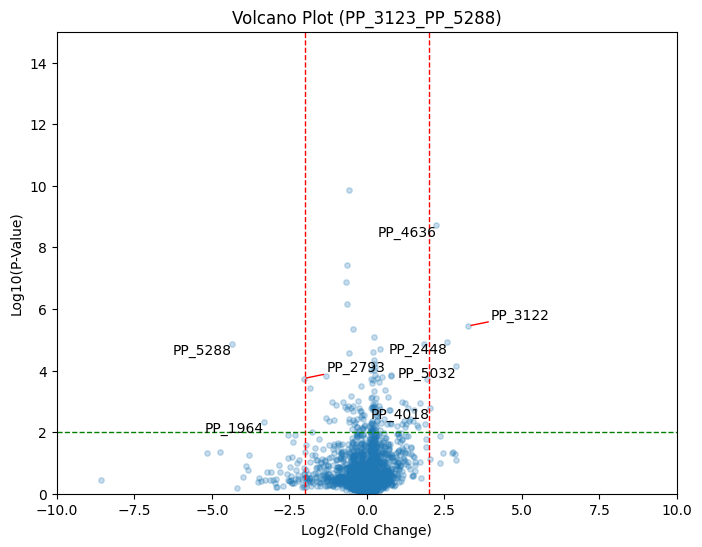

4


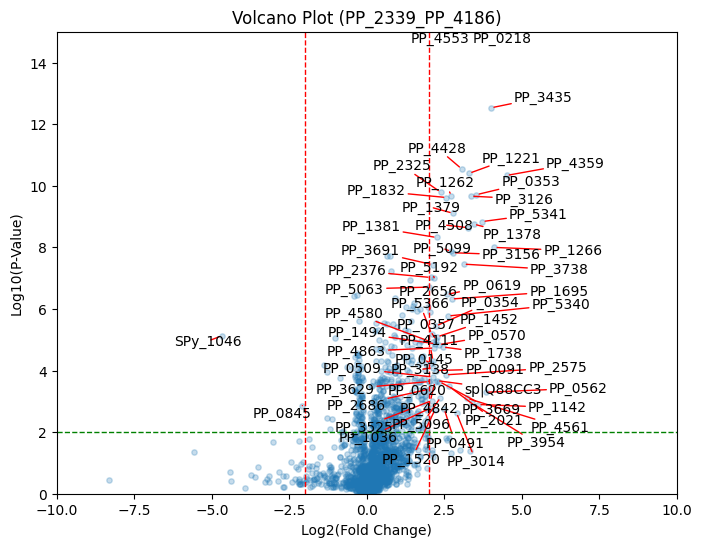

5


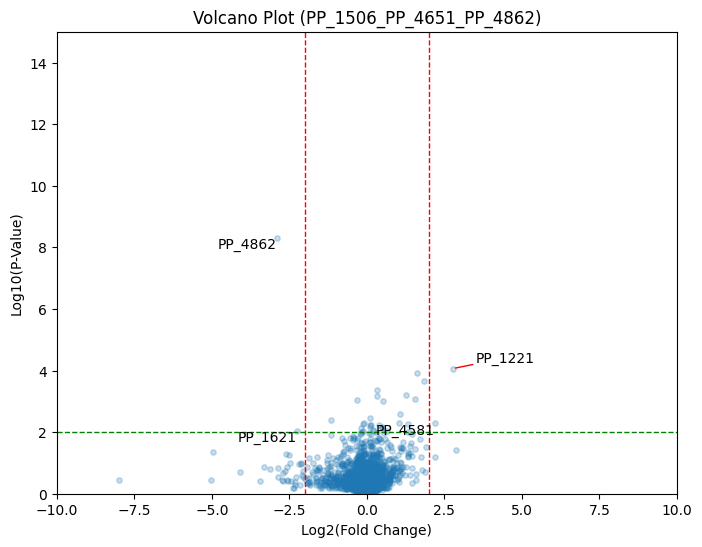

6


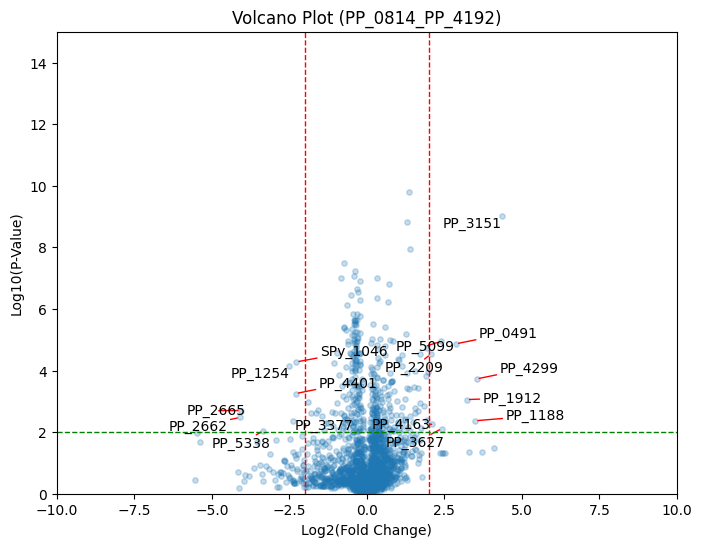

7


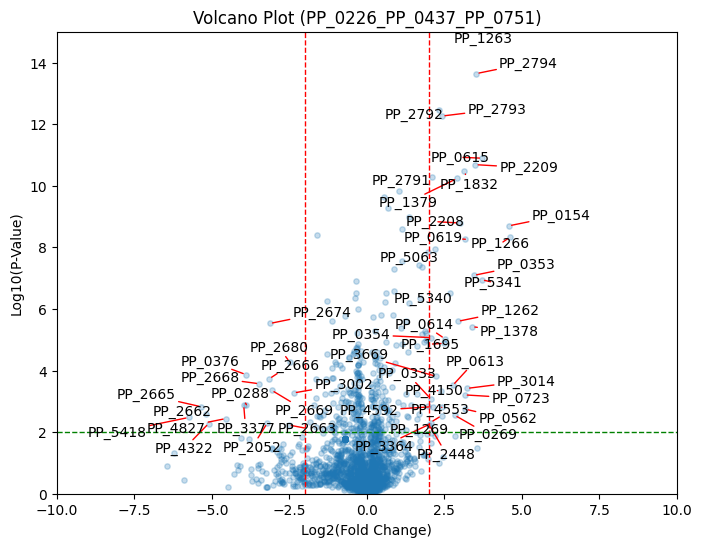

8


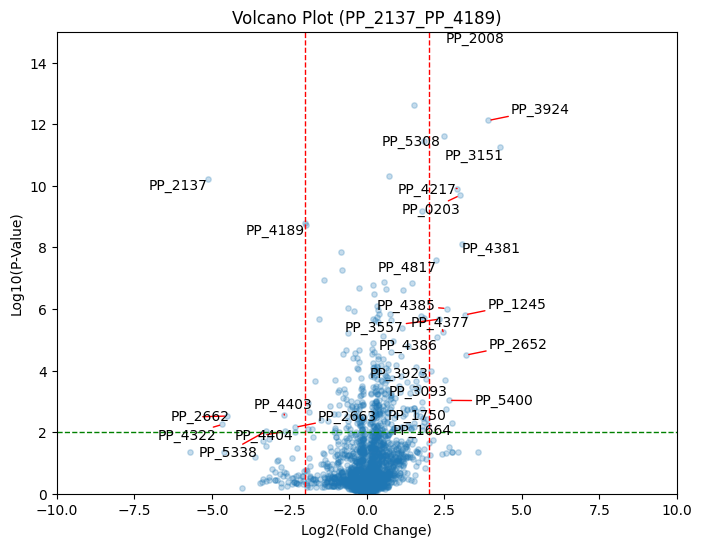

9


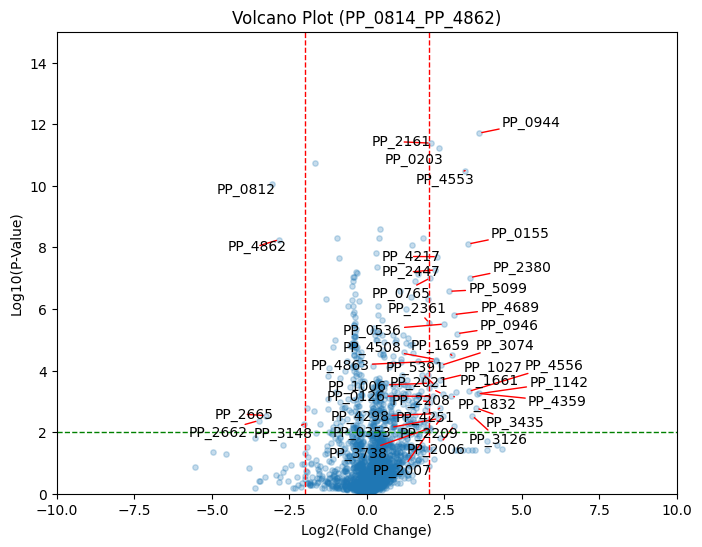

10


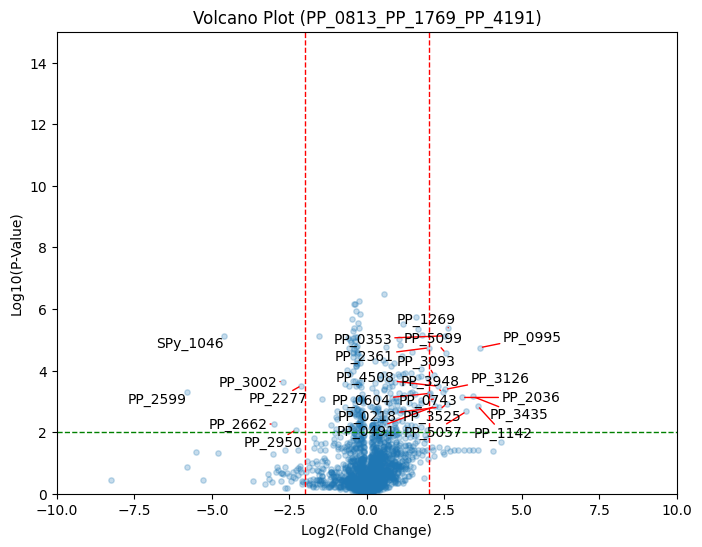

11


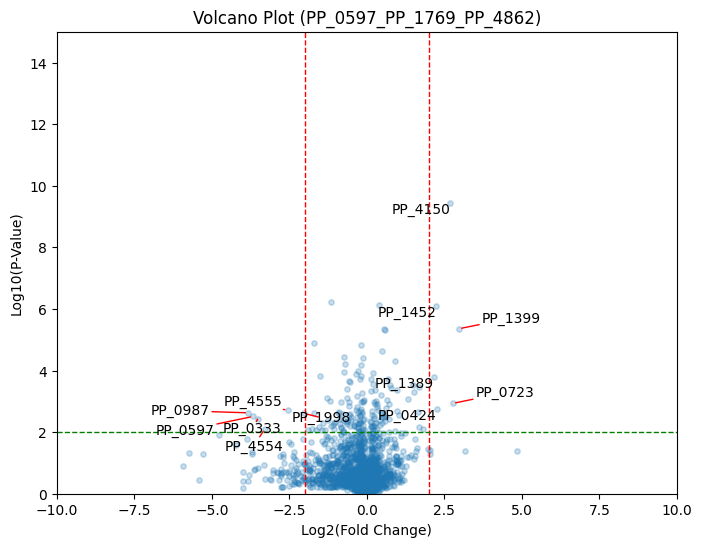

12


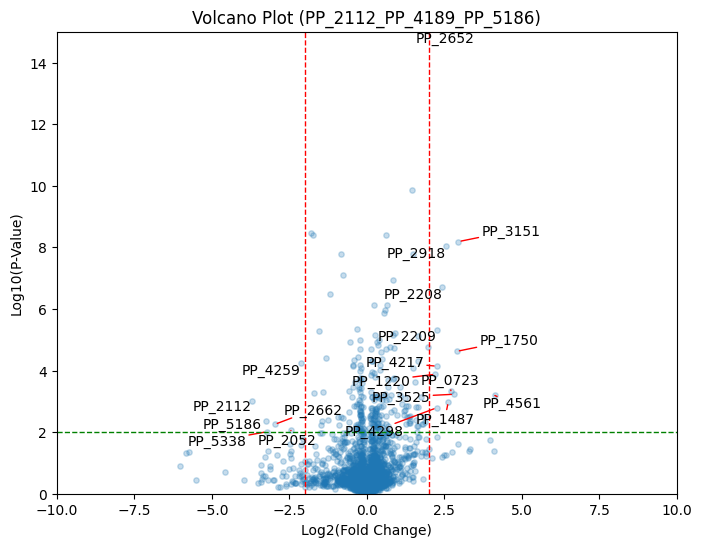

13


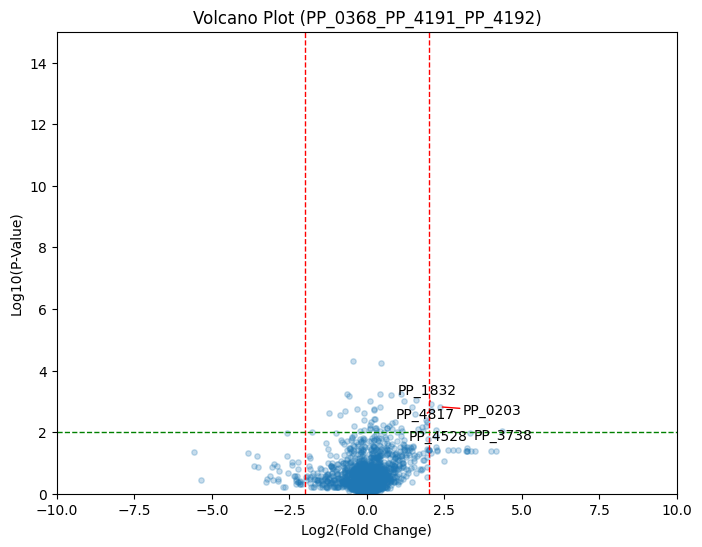

14


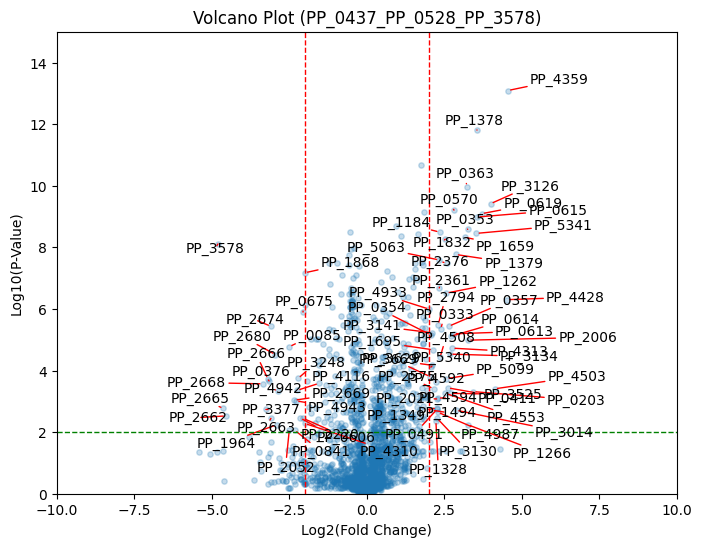

15


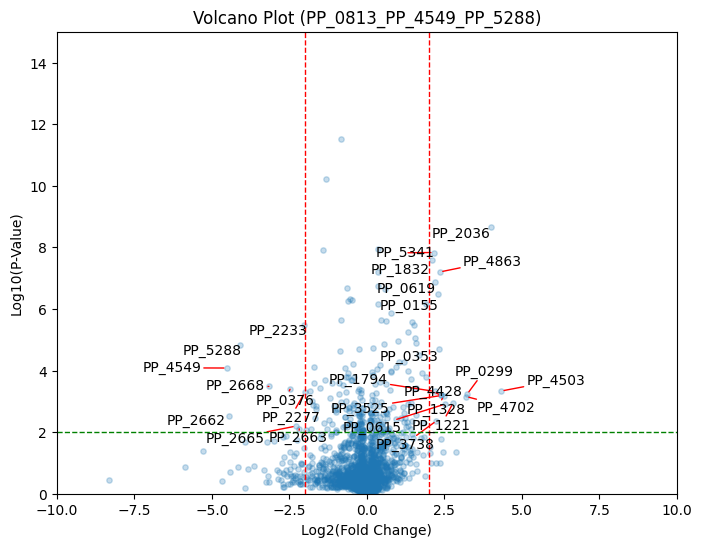

16


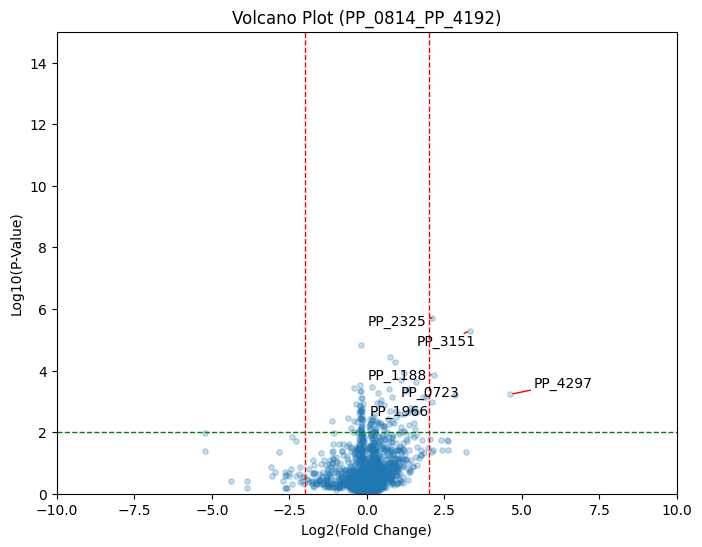

17


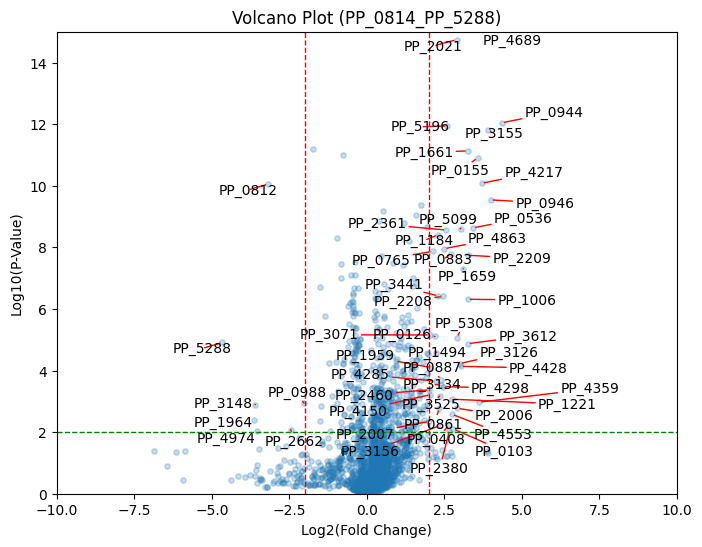

18


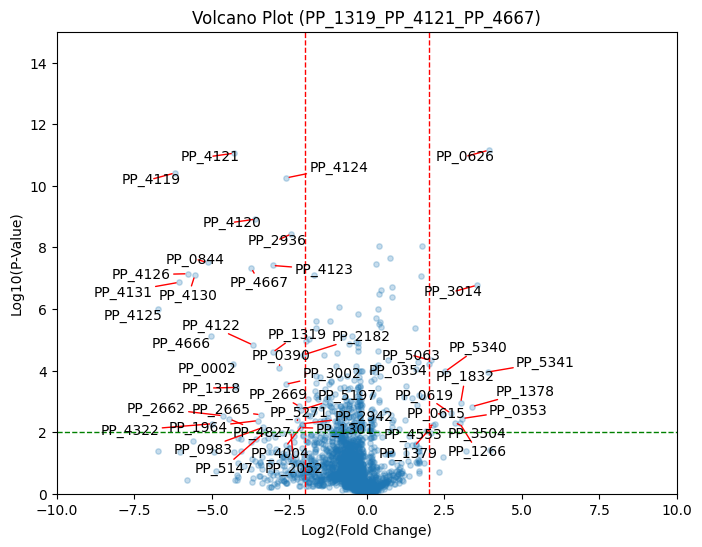

19


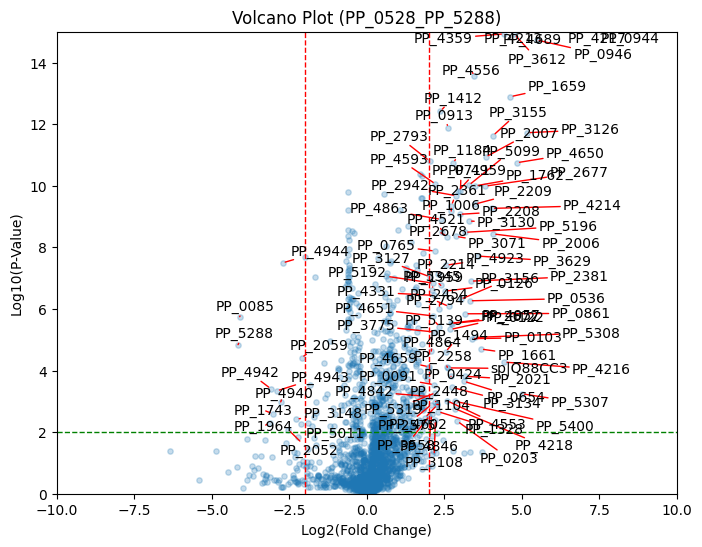

20


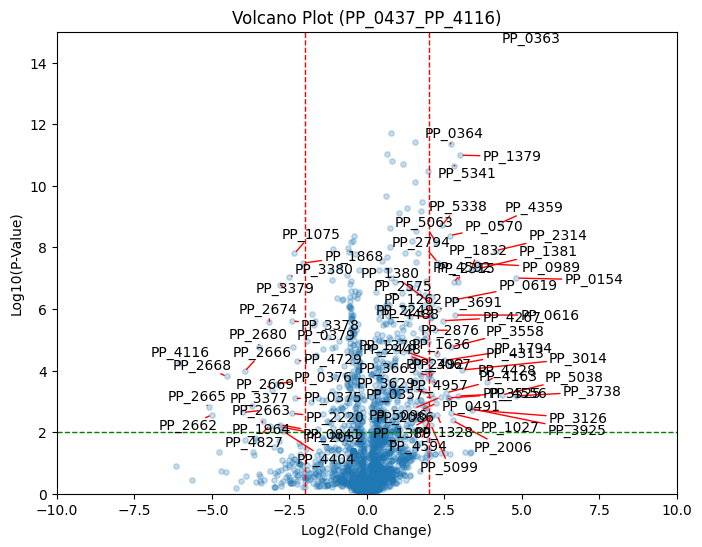

21


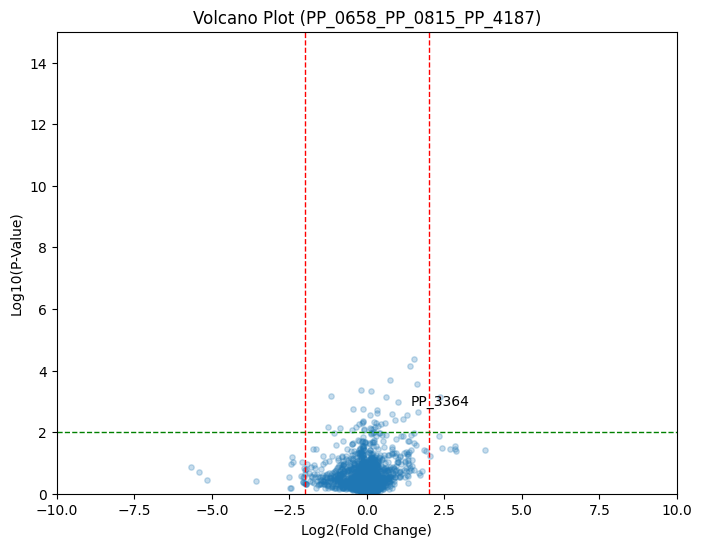

22


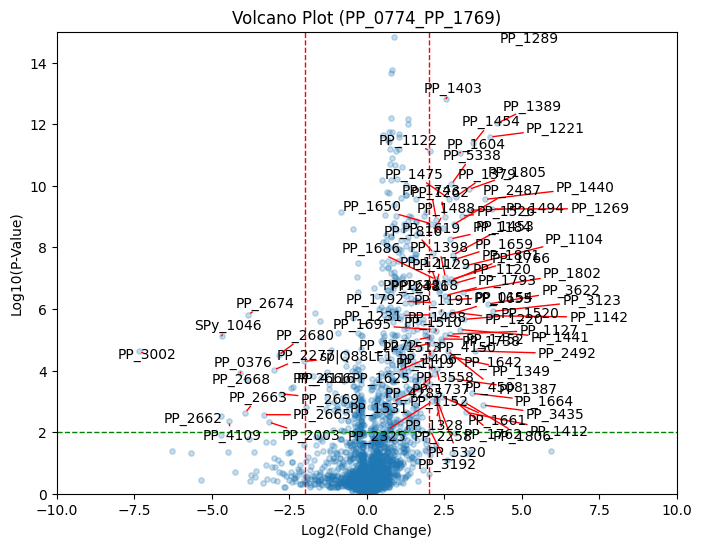

23


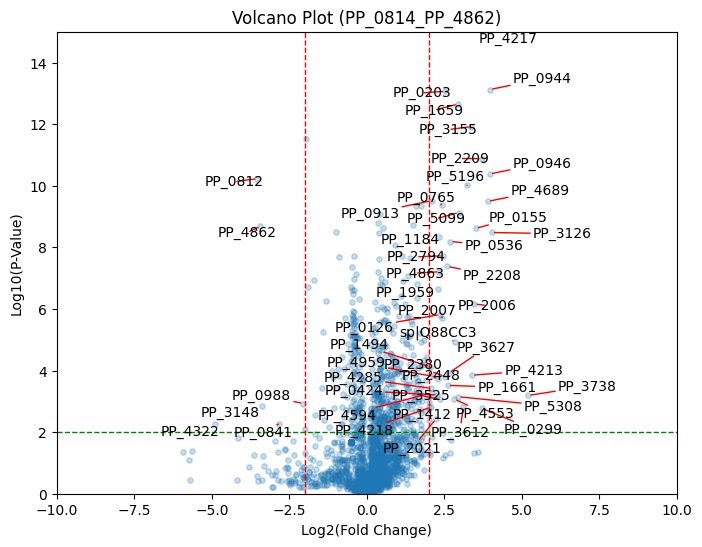

24


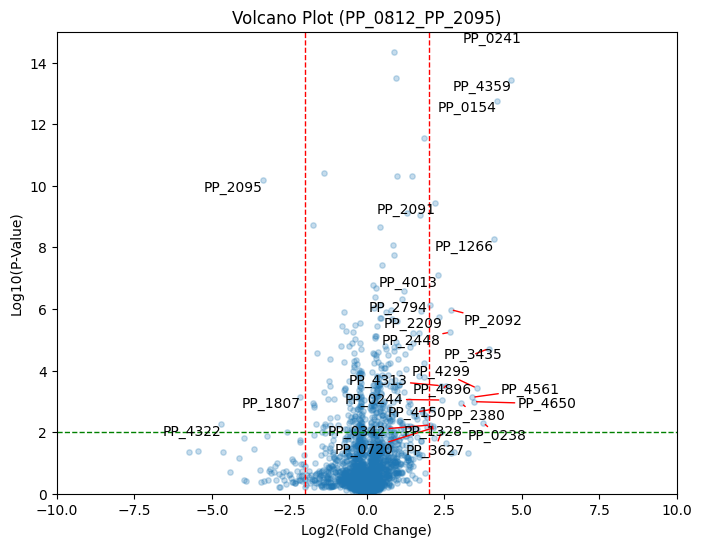

25


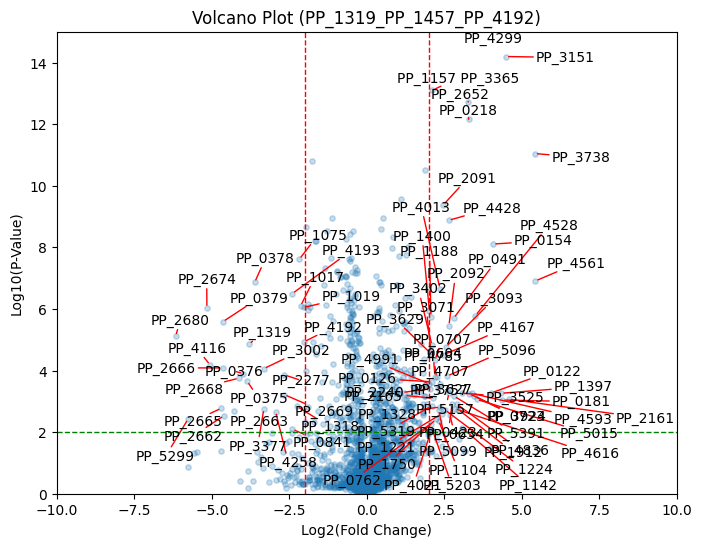

26


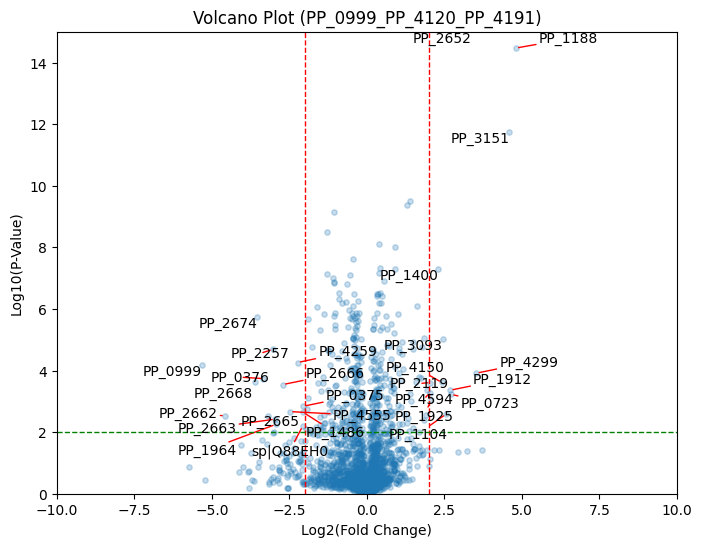

27


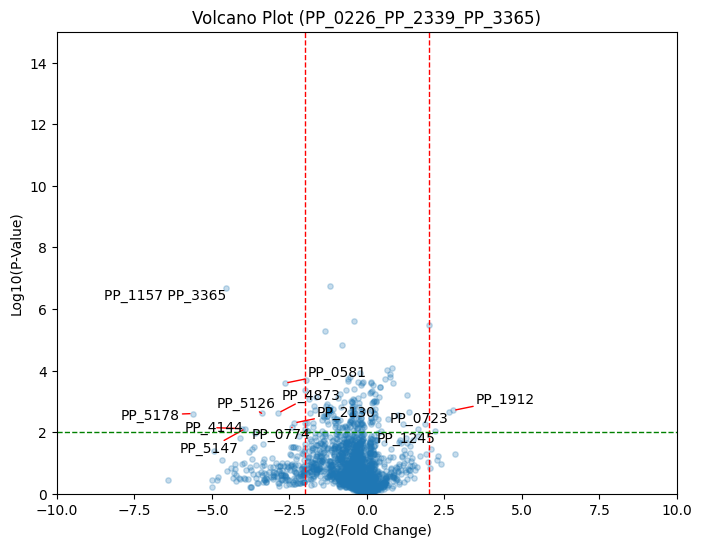

28


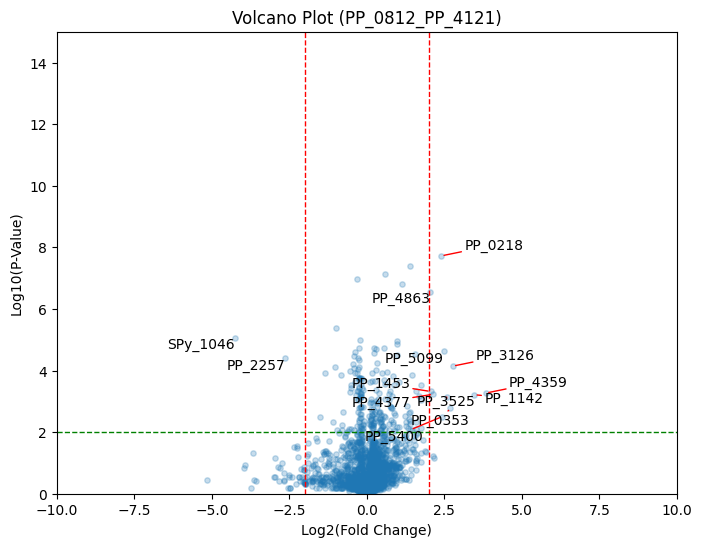

29


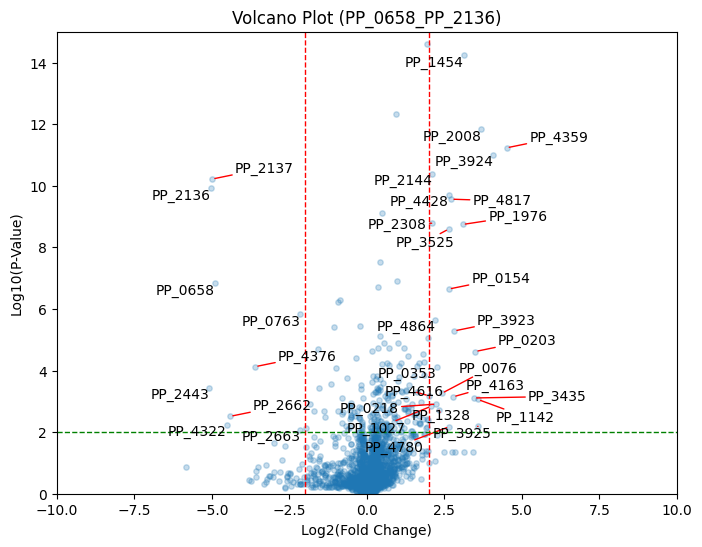

30


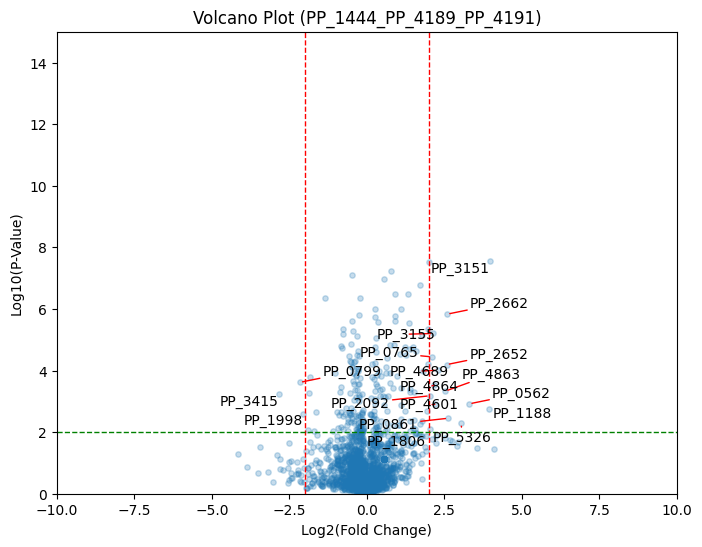

31


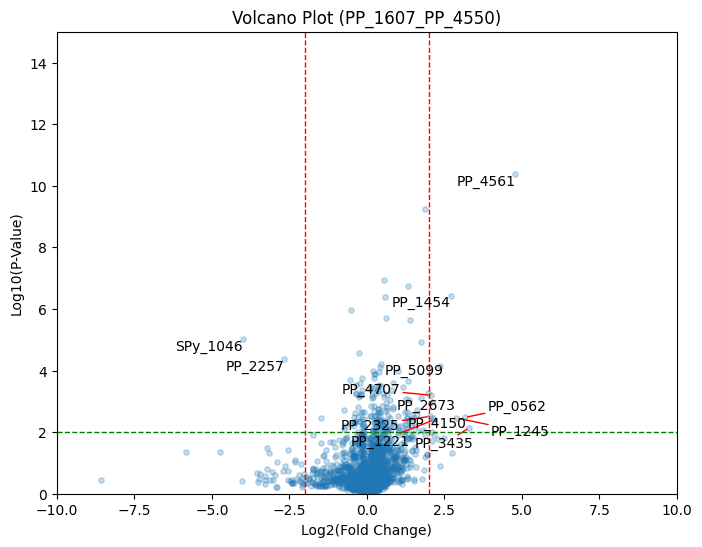

32


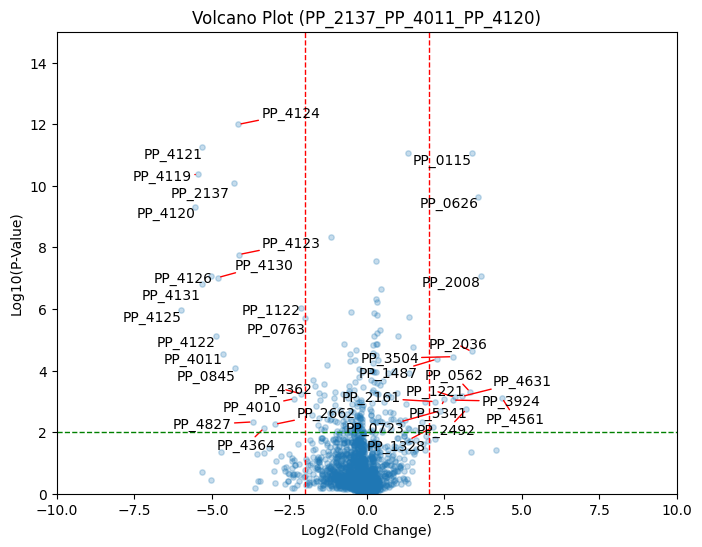

33


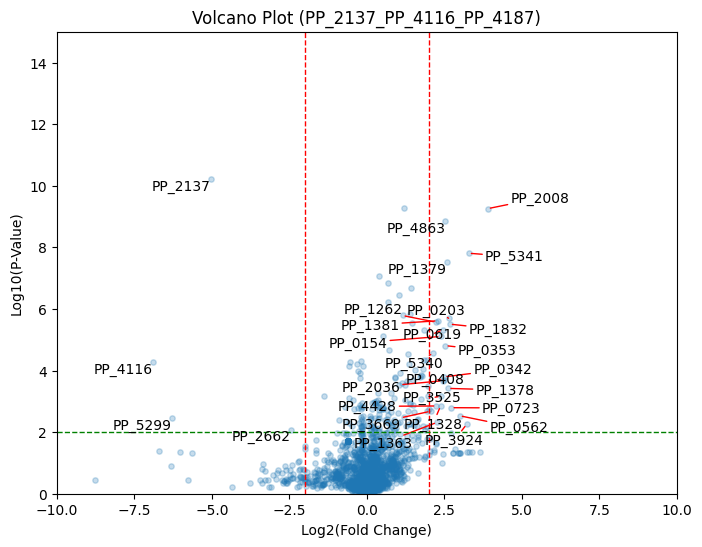

34


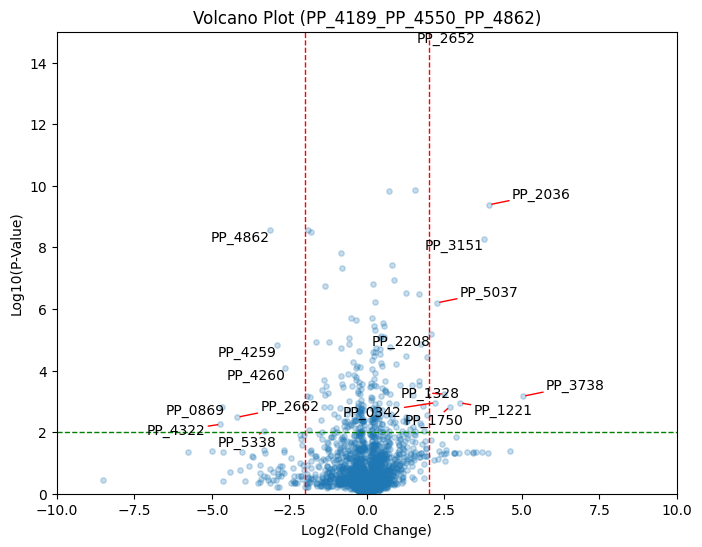

35


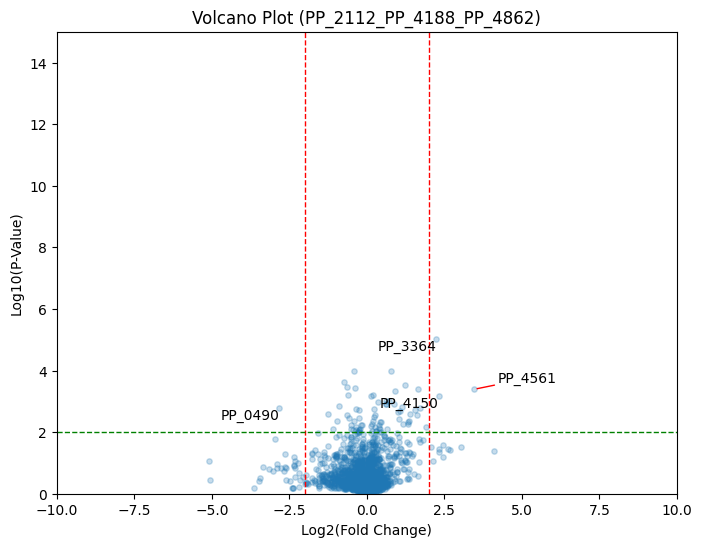

36


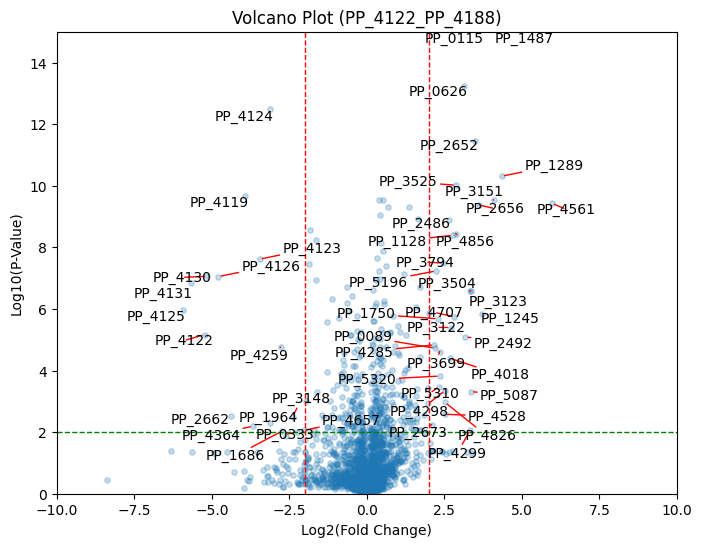

37


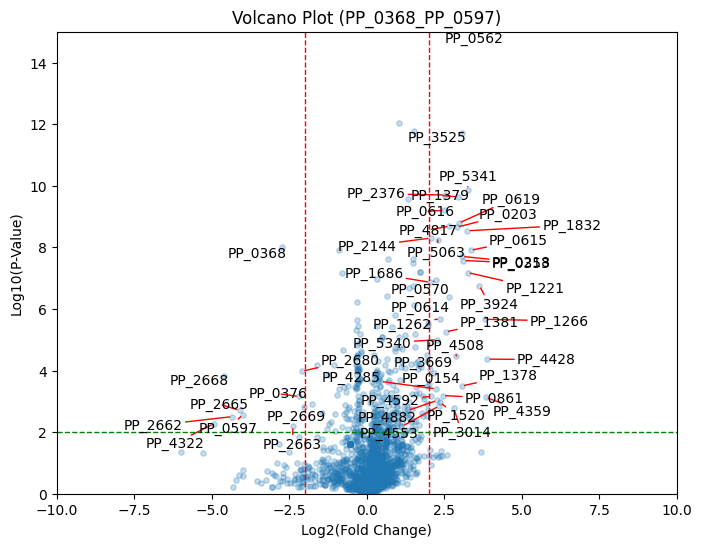

38


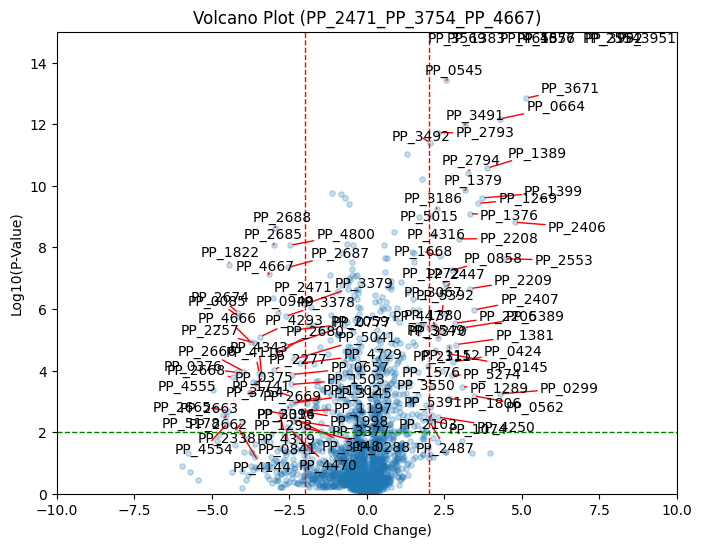

39


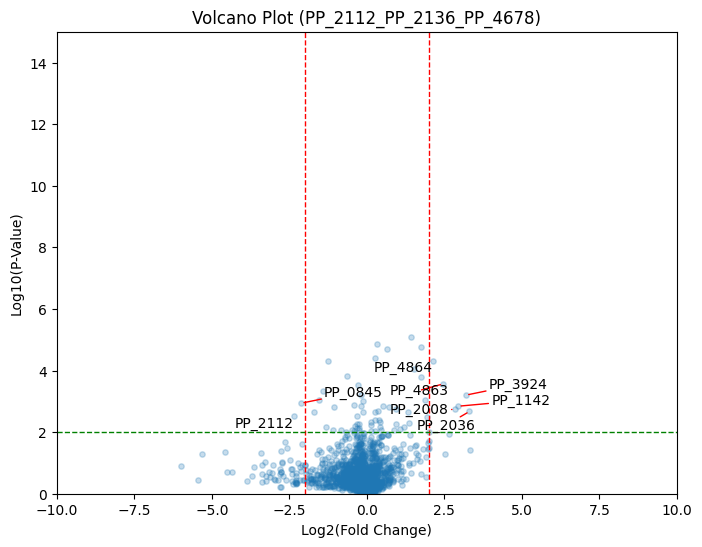

40


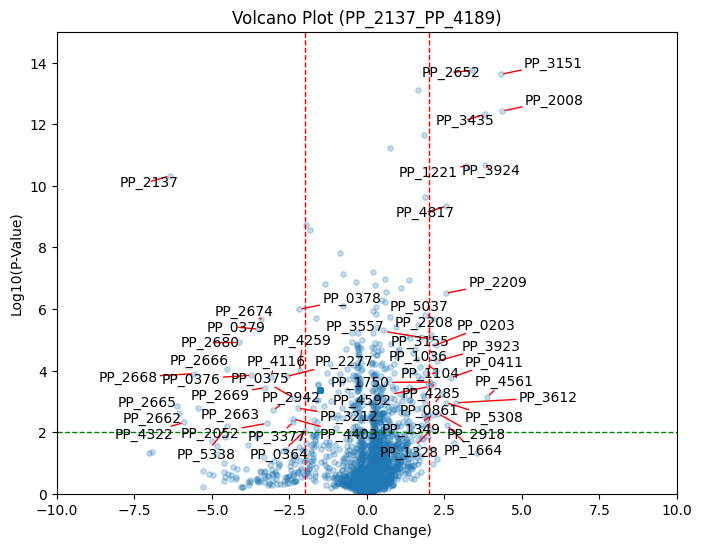

41


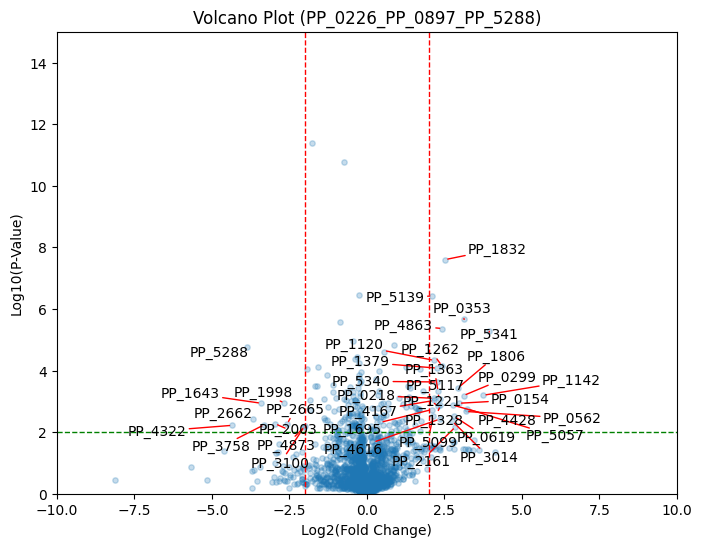

42


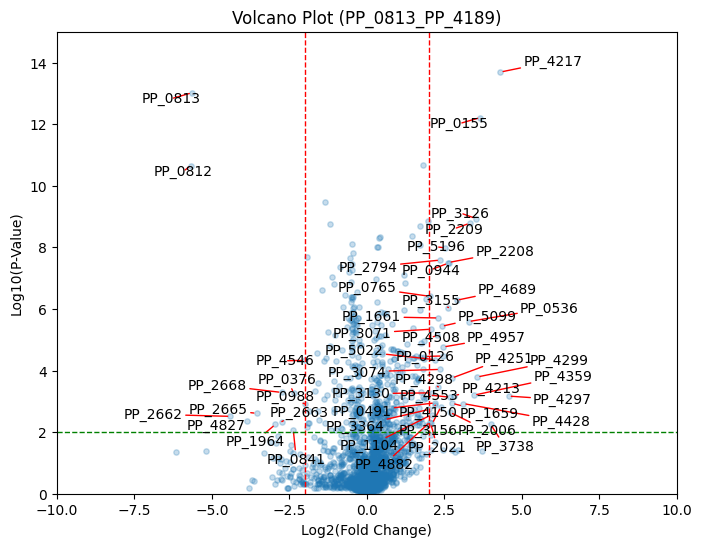

43


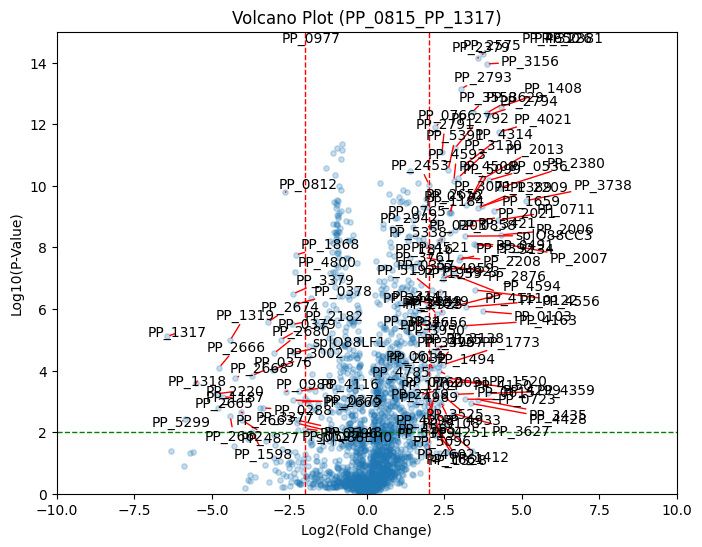

44


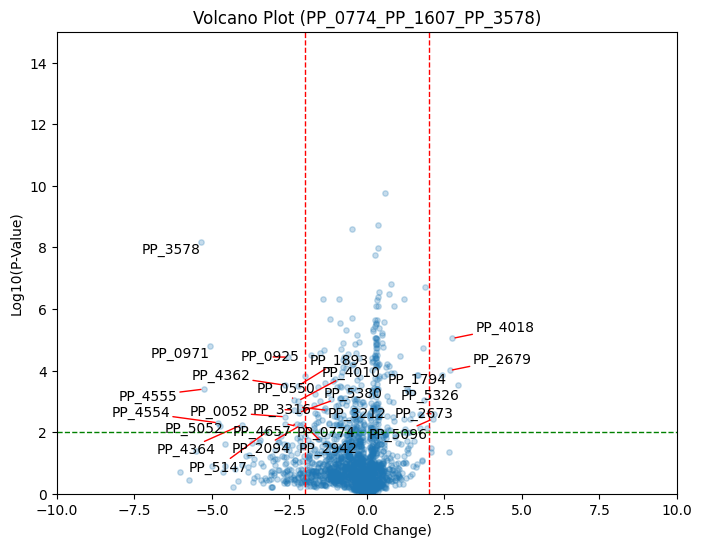

45


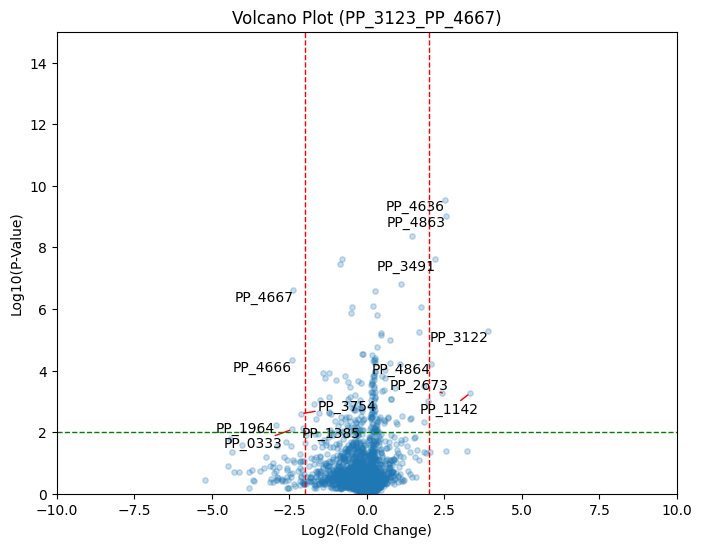

46


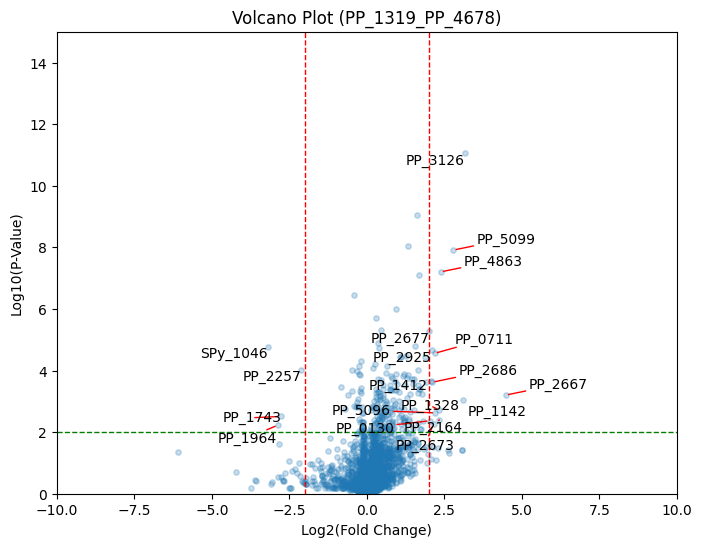

47


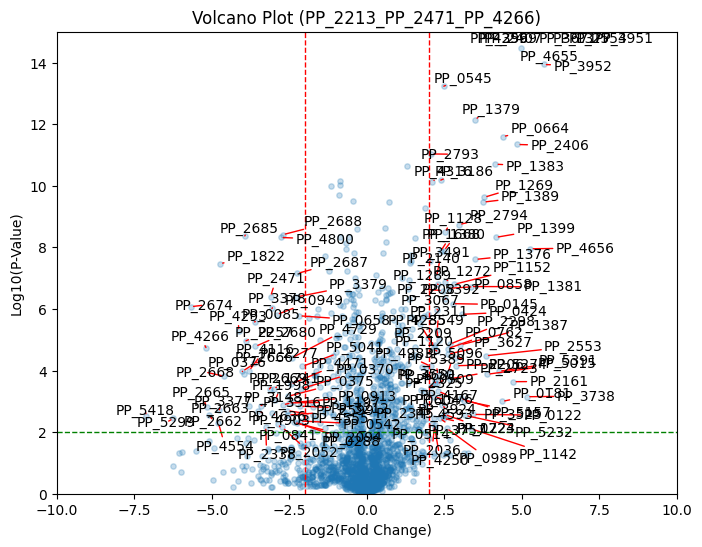

48


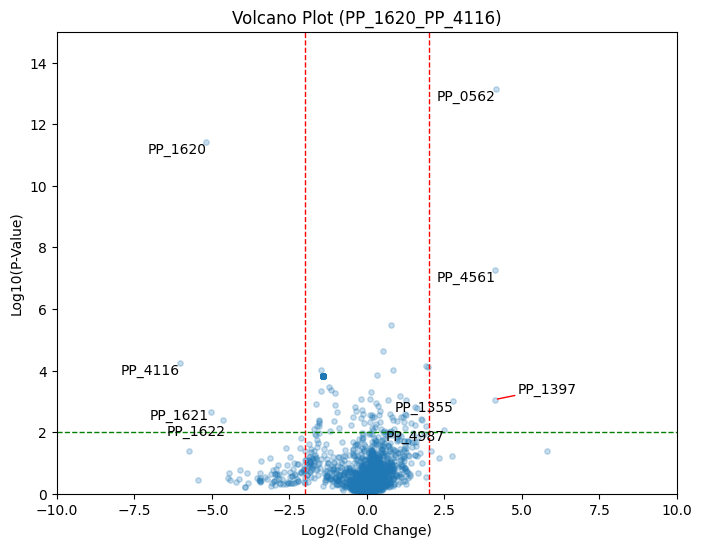

49


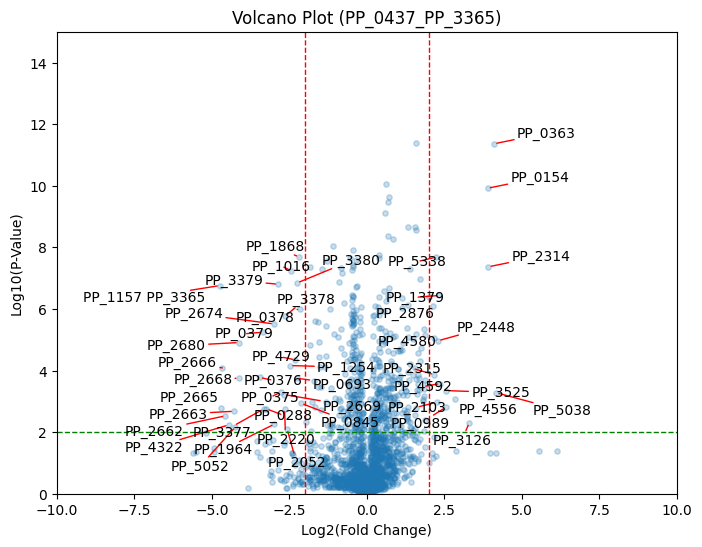

50


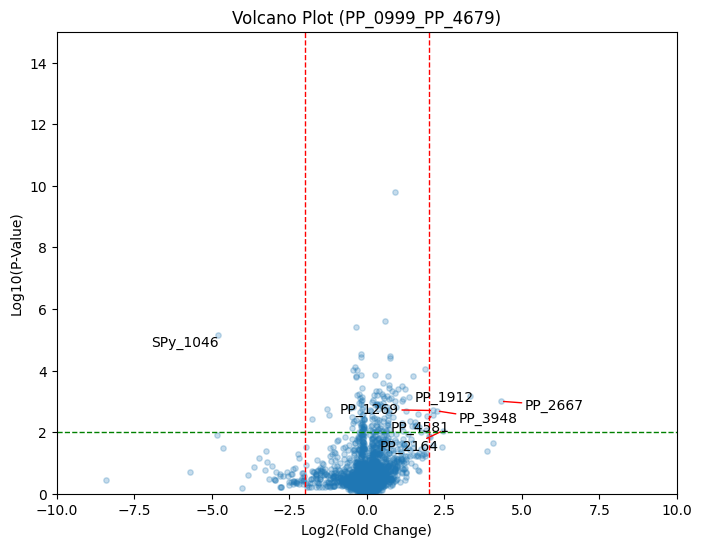

51


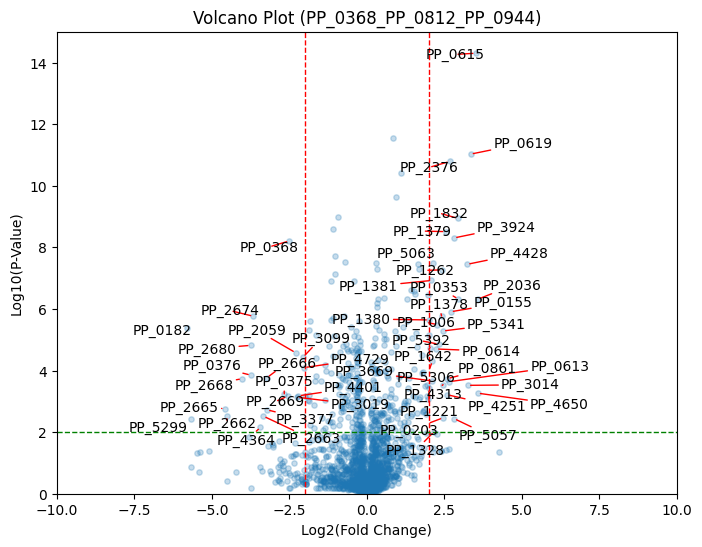

52


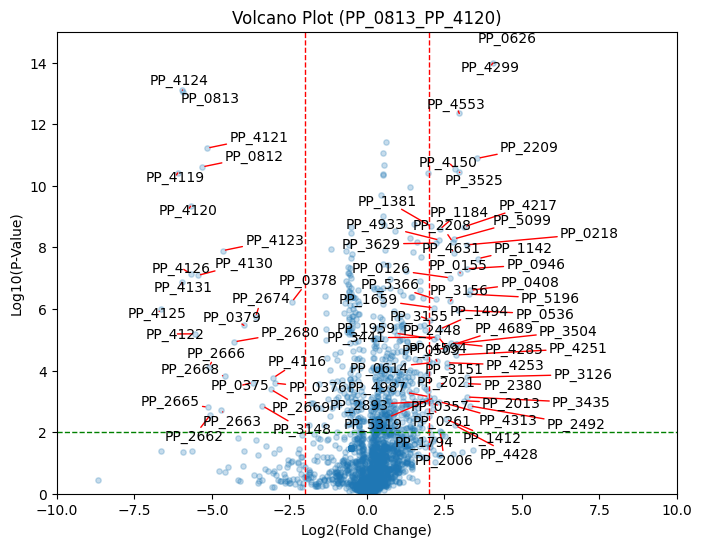

53


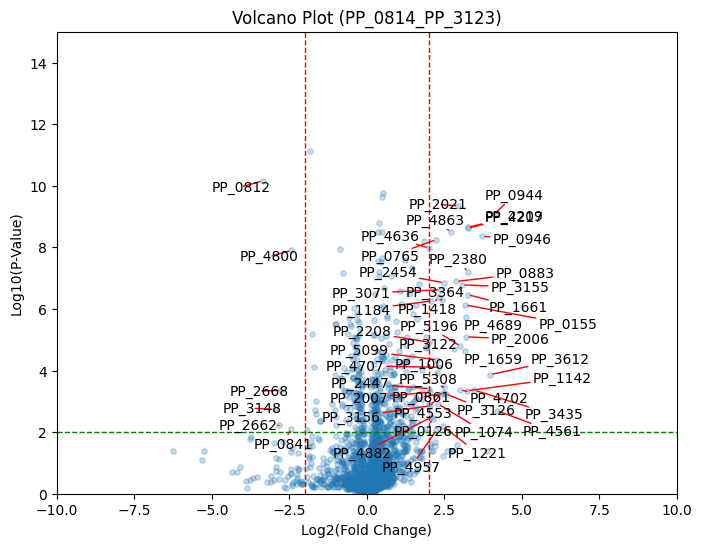

54


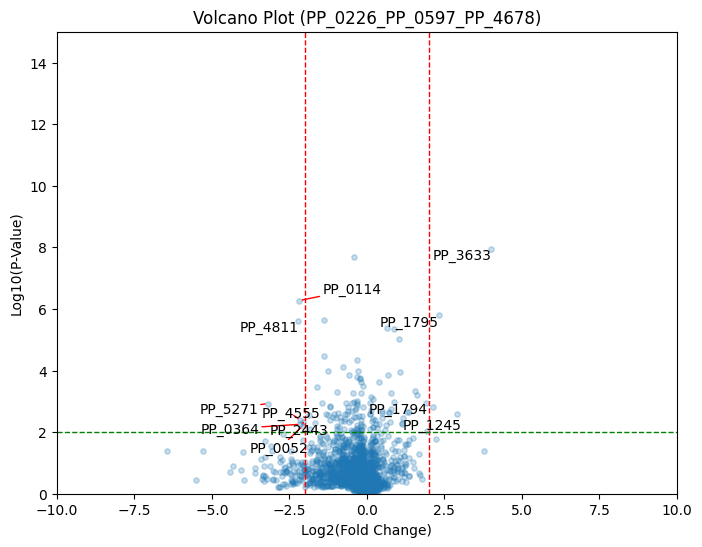

55


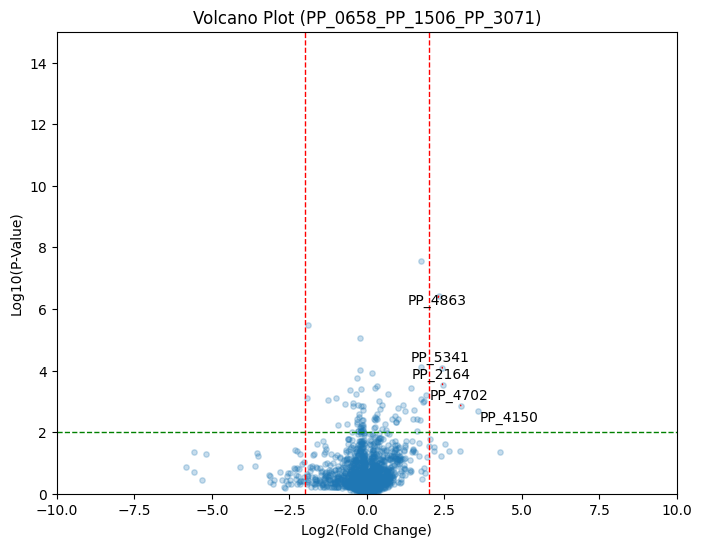

56


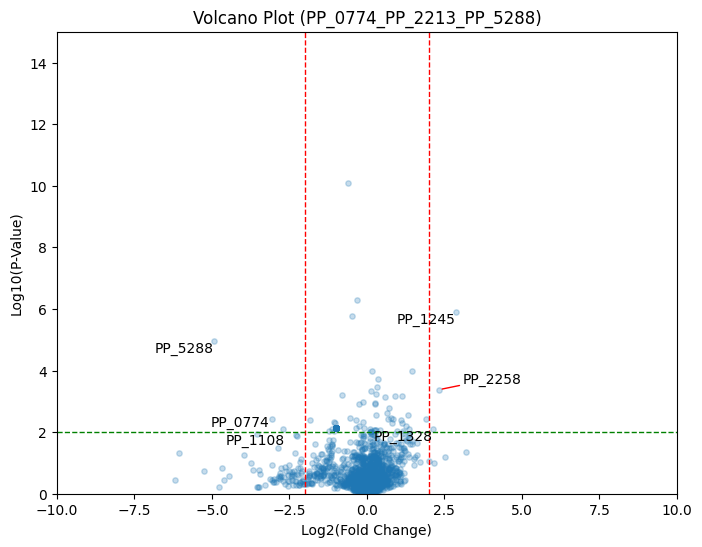

57


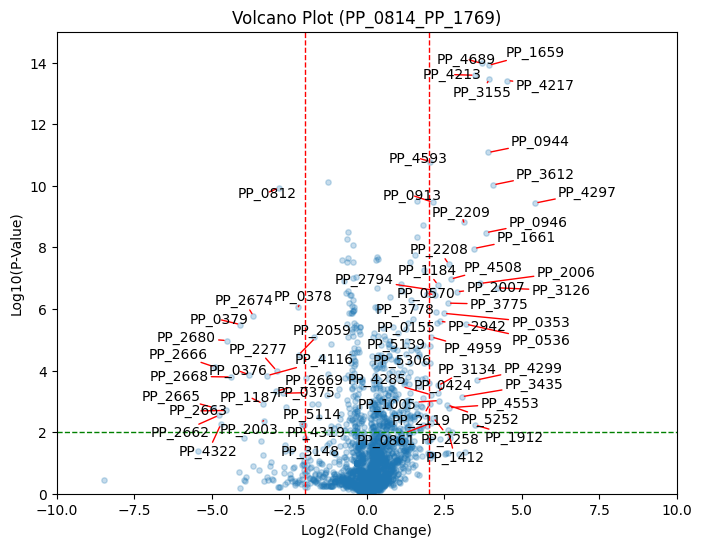

58


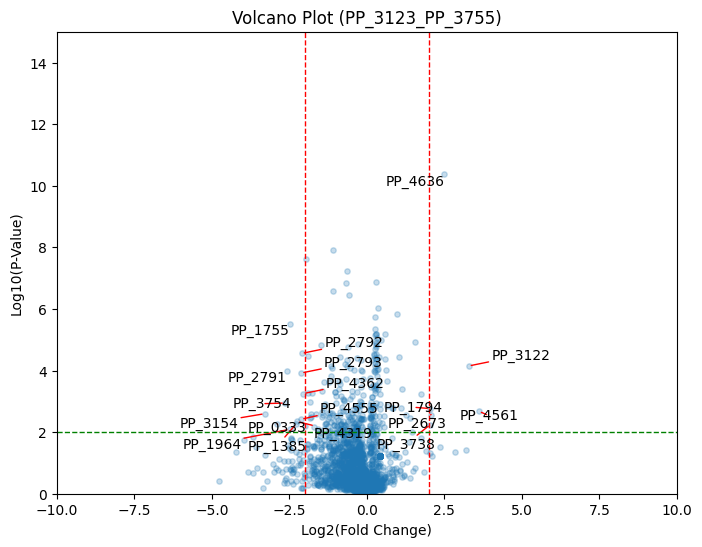

59


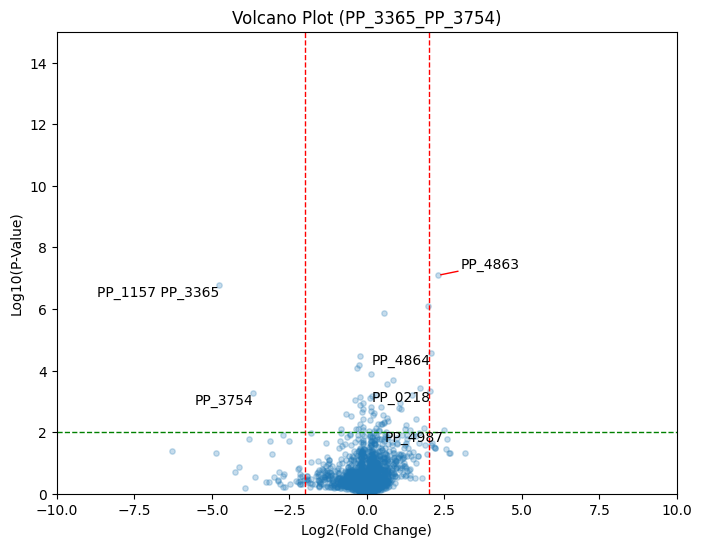

60


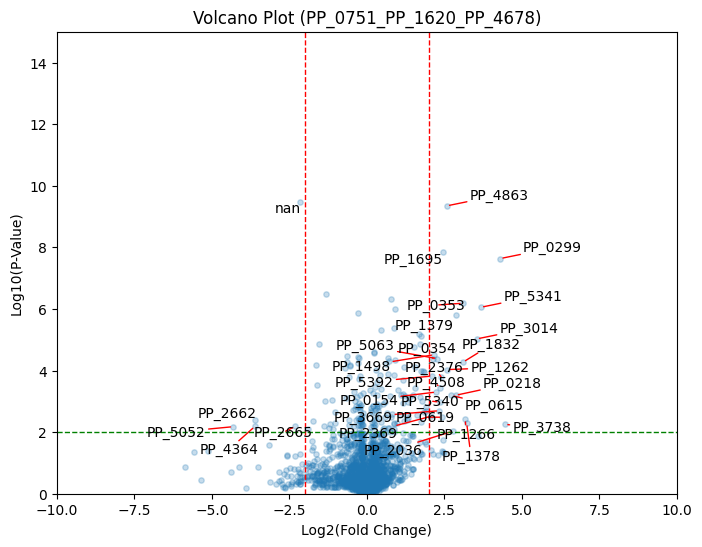

In [10]:
#Iterate through common columns and create volcano plots
for k,column in enumerate(common_columns,start=1):
    fold_change = df_log2[column]
    p_values = df_log10[column]

    #Customize the volcano plot with fold change and p-values
    fig = plt.figure(figsize=(8, 6))
    
    #Adjust marker size and transparency as needed
    plt.scatter(fold_change, p_values, s=15, alpha=0.25) 
    plt.title(f"Volcano Plot ({column[:-3]})")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0,15)
    plt.xlim(-10,10)

    #Add horizontal and vertical lines to indicate  thresholds
    plt.axvline(x=2, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=-2, color='r', linestyle='--', linewidth=1)
    #Example threshold for p-value p<0.01
    plt.axhline(y=-np.log10(0.01), color='g', linestyle='--', linewidth=1) 
    
    #Annotate the points with protein names and adjust for label overlap
    texts=[]
    labels_prot = [df_log2.iloc[i, 0] for i in range(len(fold_change))]
    labels = [translator_dict[orig_label] for orig_label in labels_prot]
    # labels_pp = 
    for i, label in enumerate(labels):
        if fold_change[i] < -2 and p_values[i] > -np.log10(0.01):
            text = plt.text(fold_change[i], p_values[i], label, fontsize=10) 
            texts.append(text)
        if fold_change[i] > 2 and p_values[i] > -np.log10(0.01):
            text = plt.text(fold_change[i], p_values[i], label, fontsize=10) 
            texts.append(text)
            
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))
    
    #Print Figure #, total figures = 60 for 60 strains (some duplicates)
    print(k)
    
    #Show the volcano plot
    plt.show()
    
    #save figure
    f_name = f"./outputs/volcano_strain_{column[:-3]}.png"
    fig.savefig(f_name)    